# DenseNet121 Centralized Baseline

This notebook loads the classification manifest, builds train/val/test splits, and fine-tunes a frozen DenseNet121 head for 8 epochs using the centralized training utilities.

In [1]:
#from pathlib import Path
#import sys

#repo_root = Path("/workspace")  # replace with your repo root
#if str(repo_root) not in sys.path:
    #sys.path.append(str(repo_root))
#%load_ext autoreload
#%autoreload 2

In [2]:
import wandb
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import shutil
import os                              # Import the 'os' module for changing directories
os.chdir('/content/drive/MyDrive/BRISC2025_FL')  # Change the directory

Mounted at /content/drive


In [3]:
from pathlib import Path
import sys

In [4]:
import os
os.getcwd()

'/content/drive/MyDrive/BRISC2025_FL'

In [5]:
!ls

checkpoints  data  experiments	training  wandb


In [6]:
!ls data

brisc2025			  __init__.py  manifests    __pycache__
build_classification_manifest.py  loader.py    prova.ipynb  utils.py


In [7]:
import pandas as pd
from data.loader import split_manifest_dataframe, build_datasets_from_manifest
from torch.utils.data import DataLoader

manifest_path = Path("data/manifests/classification_manifest.csv")
base_dir = Path("data/brisc2025")

train_df, val_df, test_df = split_manifest_dataframe(
    manifest_path=manifest_path,
    train_split_value="train",
    test_split_value="test",
    val_fraction=0.2,
    stratify_columns=("tumor", "plane"),
    random_state=42,
)

print(f"train rows: {len(train_df)} | val rows: {len(val_df)} | test rows: {len(test_df)}")
display(train_df.head())

train rows: 4000 | val rows: 1000 | test rows: 1000


,filename,path,split,index,tumor,plane,sequence,label,_strata
0,brisc2025_train_00592_gl_co_t1.jpg,classification_task/train/glioma/brisc2025_tra...,train,592,glioma,co,t1,0,glioma_co
1,brisc2025_train_04803_pi_sa_t1.jpg,classification_task/train/pituitary/brisc2025_...,train,4803,pituitary,sa,t1,3,pituitary_sa
2,brisc2025_train_00818_gl_co_t1.jpg,classification_task/train/glioma/brisc2025_tra...,train,818,glioma,co,t1,0,glioma_co
3,brisc2025_train_01156_me_ax_t1.jpg,classification_task/train/meningioma/brisc2025...,train,1156,meningioma,ax,t1,1,meningioma_ax
4,brisc2025_train_02610_no_ax_t1.jpg,classification_task/train/no_tumor/brisc2025_t...,train,2610,no_tumor,ax,t1,2,no_tumor_ax


In [8]:
BATCH_SIZE = 32
NUM_WORKERS = 2
NUM_CLASSES = 4
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4
NUM_EPOCHS = 8
CHECKPOINT_INTERVAL = 2

In [9]:
train_set, val_set, test_set = build_datasets_from_manifest(
    manifest_path=manifest_path,
    base_dir=base_dir,
    train_split_value="train",
    test_split_value="test",
    val_fraction=0.2,
    stratify_columns=("tumor", "plane"),
    random_state=42,
)

batch_size = BATCH_SIZE
num_workers = NUM_WORKERS  # set to 0 if running on an environment without worker support

loader_kwargs = dict(batch_size=batch_size, num_workers=num_workers, pin_memory=True)

train_loader = DataLoader(train_set, shuffle=True, drop_last=False, **loader_kwargs)
val_loader = DataLoader(val_set, shuffle=False, drop_last=False, **loader_kwargs)
test_loader = DataLoader(test_set, shuffle=False, drop_last=False, **loader_kwargs)

len(train_set), len(val_set), len(test_set)

(4000, 1000, 1000)

In [10]:
import wandb
# 82fcb15fccd81a5d9dfd0b6c56bdd318ba7d071f
wandb.login()

wandb: Currently logged in as: depetrofabio (depetrofabio-politecnico-di-torino) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [11]:
!ls training

centralized_training.py  FL_training.py  __pycache__
checkpointing.py	 __init__.py


In [12]:
import torch
import torch.nn as nn
from torchvision import models

num_classes = NUM_CLASSES
weights = models.DenseNet121_Weights.IMAGENET1K_V1
model = models.densenet121(weights=weights)

for param in model.features.parameters():
    param.requires_grad = False

in_features = model.classifier.in_features
model.classifier = nn.Linear(in_features, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
device

device(type='cuda')

In [13]:
checkpoint_dir = Path("checkpoints")
checkpoint_dir.mkdir(parents=True, exist_ok=True)
checkpoint_path = checkpoint_dir / "densenet121_centralized_head.pth"

In [14]:
str(checkpoint_path)

'checkpoints/densenet121_centralized_head.pth'

In [15]:
from training.centralized_training import train_and_validate
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

checkpoint_dir = Path("checkpoints")
checkpoint_dir.mkdir(parents=True, exist_ok=True)
checkpoint_path = checkpoint_dir / "densenet121_centralized_headprova.pth"

model_name = "densenet121_centralized_head"
project_name = "BaselineCentralized_DenseNet"
run_name = model_name

wandb.init(
    project=project_name,
    name=run_name,
    id=run_name,
    config={
        "model": model_name,
        "epochs": NUM_EPOCHS,
        "batch_size": train_loader.batch_size,
        "learning_rate": LEARNING_RATE,
        "weight_decay": WEIGHT_DECAY,
        "architecture": model.__class__.__name__,
    },
)

final_val_acc = train_and_validate(
    start_epoch=1,
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    scheduler=scheduler,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    checkpoint_path=str(checkpoint_path),
    num_epochs=NUM_EPOCHS,
    checkpoint_interval=CHECKPOINT_INTERVAL,
)

wandb.finish()
print(f"Final validation accuracy: {final_val_acc:.2f}%")


[Epoch 1] Train Loss: 0.7565, Train Accuracy: 74.17%, Val Loss: 0.4855, Val Accuracy: 84.30
current LR: [0.001]
[Epoch 2] Train Loss: 0.4361, Train Accuracy: 86.10%, Val Loss: 0.3678, Val Accuracy: 86.70
current LR: [0.001]
Checkpoint salvato su: checkpoints/densenet121_centralized_headprova.pth
[Epoch 3] Train Loss: 0.3706, Train Accuracy: 86.70%, Val Loss: 0.3399, Val Accuracy: 87.60
current LR: [0.001]
[Epoch 4] Train Loss: 0.3254, Train Accuracy: 89.20%, Val Loss: 0.3009, Val Accuracy: 89.20
current LR: [0.0001]
Checkpoint salvato su: checkpoints/densenet121_centralized_headprova.pth
[Epoch 5] Train Loss: 0.3026, Train Accuracy: 89.60%, Val Loss: 0.2991, Val Accuracy: 89.40
current LR: [0.0001]
[Epoch 6] Train Loss: 0.2989, Train Accuracy: 89.50%, Val Loss: 0.2975, Val Accuracy: 89.30
current LR: [0.0001]
Checkpoint salvato su: checkpoints/densenet121_centralized_headprova.pth
[Epoch 7] Train Loss: 0.2969, Train Accuracy: 89.83%, Val Loss: 0.2938, Val Accuracy: 89.60
current LR: [0

epoch,▁▂▃▄▅▆▇█
train_accuracy,▁▆▇█████
train_loss,█▃▂▁▁▁▁▁
val_accuracy,▁▄▅▇▇▇██
val_loss,█▄▃▁▁▁▁▁
epoch,8
train_accuracy,89.575
train_loss,0.29612
val_accuracy,89.9
val_loss,0.29096


Final validation accuracy: 89.90%


In [ ]:
from training.centralized_training import test_epoch

test_loss, test_accuracy = test_epoch(model, test_loader, criterion, device)
print(f"Test loss: {test_loss:.4f} | Test accuracy: {test_accuracy:.2f}%")

wandb.finish()

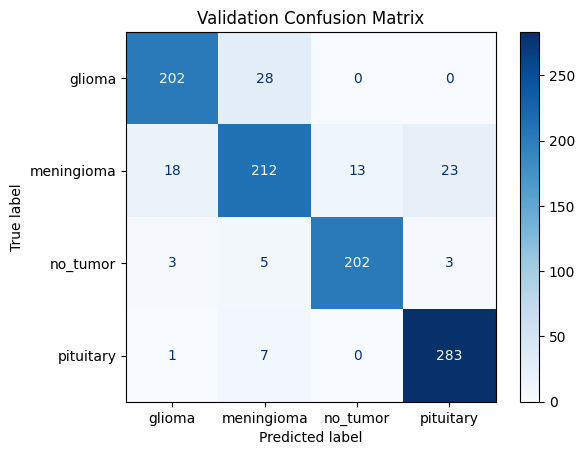

In [18]:
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(labels.cpu().numpy())

cm = confusion_matrix(all_targets, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["glioma", "meningioma", "no_tumor", "pituitary"])
disp.plot(cmap="Blues")
plt.title("Validation Confusion Matrix")
plt.show()
